## Imports

In [1]:
import io
import os
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

tf.get_logger().setLevel("ERROR")

from tensorflow import keras
from keras import layers

import sklearn.neighbors as sk_neighbors
import sklearn.model_selection as sk_model

import numpy as np
import pandas as pd

from skimage import filters

import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from tqdm.notebook import tqdm
import sklearn

## Settings

In [2]:
# dataset = "caltech_birds2011"
dataset = "fss_100"

num_classes = 200
img_size = 220

img_width  = img_size
img_height = img_size

batch_size = 16

epochs = 20

## Load dataset

In [3]:
if dataset == "caltech_birds2011":

    (train_ds_original, val_ds_original), ds_info = tfds.load(
        "caltech_birds2011", 
        split=["train", "test"], 
        as_supervised=True,
        shuffle_files=True,
        with_info=True,
    )

In [4]:
if dataset == "fss_100":
    builder = tfds.ImageFolder("input")
    
    ds_info = builder.info
    (train_ds_original, val_ds_original) = builder.as_dataset(
        split=["train", "val"], 
        as_supervised=True, 
        shuffle_files=True,
    )

Training:   8004
Validation: 2002


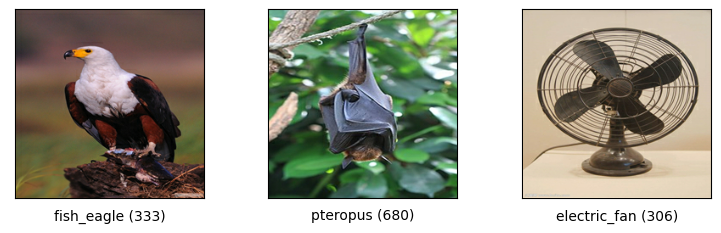

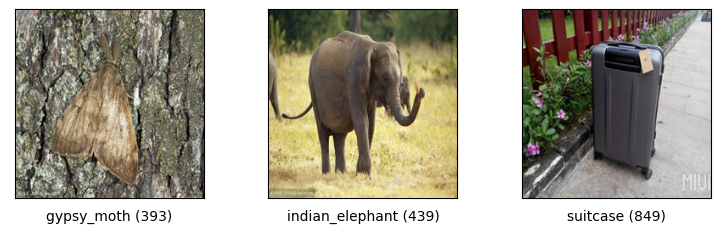

In [5]:
print("Training:   {}".format(len(train_ds_original)))
print("Validation: {}".format(len(val_ds_original)))

_ = tfds.show_examples(train_ds_original.take(3), ds_info, image_key="image")
_ = tfds.show_examples(val_ds_original.take(3), ds_info, image_key="image")

## Prepear dataset

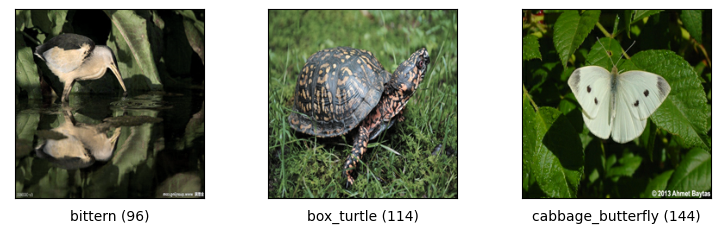

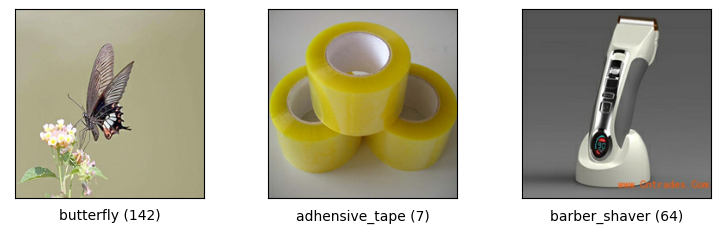

In [6]:
# Filters & augmentation
filter_labels = lambda image, label: label < num_classes

def resize_images(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)

    image = tf.image.resize_with_crop_or_pad(
        image, img_height, img_width
    )
    
    return image, label

def augment_images(image, label):
    image = tf.image.random_flip_left_right(image)

    image = tf.image.random_saturation(image, 0.2, 3)
    image = tf.image.random_hue(image, 0.04)

    return image, label

# Prepear dataset
train_ds = (
    train_ds_original
    .filter(filter_labels)
    .map(resize_images, num_parallel_calls=tf.data.AUTOTUNE)
    .map(augment_images, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

val_ds = (
    val_ds_original
    .filter(filter_labels)
    .map(resize_images, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

_ = tfds.show_examples(train_ds.take(3), ds_info, image_key="image")
_ = tfds.show_examples(val_ds.take(3), ds_info, image_key="image")

train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

## Setup model

In [7]:
model = keras.Sequential([
    # Input
    layers.InputLayer(input_shape=(img_height, img_width, 3)),

    # Block 1
    layers.BatchNormalization(),
    layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same"),
    layers.MaxPool2D(),
    
    # Block 2
    layers.BatchNormalization(),
    layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same"),
    layers.MaxPool2D(),
    
    # Block 3
    layers.BatchNormalization(),
    layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same"),
    layers.MaxPool2D(),
    
    # Head
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(256, activation=None),
    layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)),
])

# Summarize model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 220, 220, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 220, 220, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 32)     0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 110, 110, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 64)      18496     
                                                        

## Train model

In [8]:
# Prepear model
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletHardLoss(margin=1.4),
)

# Train model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
)

Epoch 1/20
101/101 [==============================] - 6s 34ms/step - loss: 0.5534 - val_loss: 1.1168
Epoch 2/20
101/101 [==============================] - 3s 28ms/step - loss: 0.3930 - val_loss: 0.9078
Epoch 3/20
101/101 [==============================] - 3s 28ms/step - loss: 0.3215 - val_loss: 0.6101
Epoch 4/20
101/101 [==============================] - 3s 29ms/step - loss: 0.2733 - val_loss: 0.4688
Epoch 5/20
101/101 [==============================] - 3s 29ms/step - loss: 0.2346 - val_loss: 0.3986
Epoch 6/20
101/101 [==============================] - 3s 29ms/step - loss: 0.2071 - val_loss: 0.3822
Epoch 7/20
101/101 [==============================] - 3s 29ms/step - loss: 0.1829 - val_loss: 0.3638
Epoch 8/20
101/101 [==============================] - 3s 29ms/step - loss: 0.1657 - val_loss: 0.3890
Epoch 9/20
101/101 [==============================] - 3s 29ms/step - loss: 0.1485 - val_loss: 0.3304
Epoch 10/20
101/101 [==============================] - 3s 28ms/step - loss: 0.1354 - val_lo

## Plot loss history

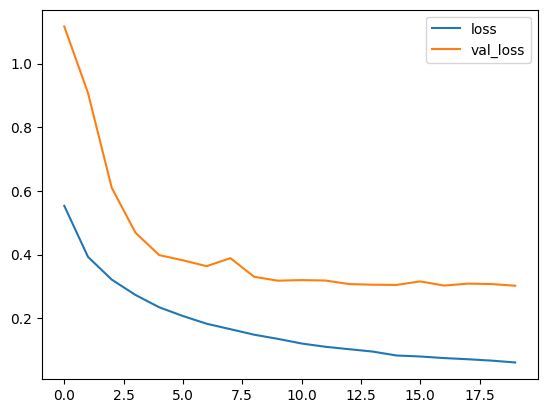

In [9]:
# Plot learning curves
history_frame = pd.DataFrame(history.history)
_ = history_frame.loc[:, ["loss", "val_loss"]].plot()

## Generate network results 

In [10]:
# Test network
test_dataset = train_ds

results = model.predict(test_dataset)

time_sufix = datetime.now().strftime("%H:%M:%S")
np.savetxt("output/vecs-" + time_sufix + ".tsv", results, delimiter="\t")

out_m = io.open("output/meta-" + time_sufix + ".tsv", "w", encoding="utf-8")
for img, labels in tfds.as_numpy(test_dataset):
    [out_m.write(str(x) + "\n") for x in labels]
out_m.close()

101/101 [==============================] - 1s 6ms/step


## Extract embiddings

In [11]:
def get_embeddings_and_labels(dataset):
    embaddings = model.predict(dataset)
    labels = np.concatenate([y.numpy() for x, y in dataset])
    assert embaddings.shape[0] == labels.shape[0]
    return embaddings, labels

train_embeddings, train_labels = get_embeddings_and_labels(train_ds)
val_embeddings, val_labels = get_embeddings_and_labels(val_ds)

26/26 [==============================] - 0s 7ms/step


## Train KNN

In [12]:
knn_finder = sk_model.GridSearchCV(
    sk_neighbors.KNeighborsClassifier(), 
    param_grid={
        "n_neighbors": [1,2,3,4,5,6,7], 
        "weights": ["uniform", "distance"],
    },
    n_jobs=-1,
)

_ = knn_finder.fit(train_embeddings, train_labels)

## Calculate accuracy

In [13]:
# Get training and validation acuuracy
knn_train_score = knn_finder.best_estimator_.score(train_embeddings, train_labels)
knn_val_score = knn_finder.best_estimator_.score(val_embeddings, val_labels)

print("Training:   {:0.2f}%".format(knn_train_score * 100))
print("Validation: {:0.2f}%".format(knn_val_score * 100))
print("Guessing:   {:0.2f}%".format(100/num_classes))
print()
print("Improvemnt: {:0.2f}".format(knn_val_score / (1/num_classes)))

Training:   100.00%
Validation: 9.98%
Guessing:   0.50%

Improvemnt: 19.95


## Extract embading distances

In [14]:
def embading_distances(embeddings, labels, samples):
    dist = tf.keras.metrics.MSE
    
    all_classes = np.unique(labels)

    pos_dists = []
    for i in tqdm(range(samples)):
        idx = np.random.choice(all_classes)
        possible_idxs = np.where(labels == idx)[0]
        choose_idx = np.random.choice(possible_idxs, size=2)

        d = dist(embeddings[choose_idx[0]], embeddings[choose_idx[1]])
        pos_dists.append(d)

    neg_dists = []
    for i in tqdm(range(samples)):
        idx = np.random.choice(all_classes)
        other_idxs = np.where(labels != idx)[0]
        choose_idx = np.random.choice(other_idxs, size=1)

        d = dist(embeddings[idx], embeddings[choose_idx[0]])
        neg_dists.append(d)
        
    pos_dists, neg_dists = sklearn.utils.shuffle(pos_dists, neg_dists)
    return pos_dists, neg_dists


num_samples = 2*10e2

train_pos_dists, train_neg_dists = embading_distances(train_embeddings, train_labels, samples=int(num_samples))
val_pos_dists, val_neg_dists = embading_distances(val_embeddings, val_labels, samples=int(num_samples))

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

## Thresholds

In [15]:
train_thresh = filters.threshold_otsu(np.concatenate([train_pos_dists, train_neg_dists]))
val_thresh = filters.threshold_otsu(np.concatenate([val_pos_dists, val_neg_dists]))

print("Train threshold: {:0.6f}".format(train_thresh))
print("Test threshold:  {:0.6f}".format(val_thresh))
print("Threshold diff:  {:0.4f}%".format((np.abs(train_thresh - val_thresh) / train_thresh)*100))

Train threshold: 0.004341
Test threshold:  0.003829
Threshold diff:  11.7859%


## Evaluate model

In [16]:
train_loss = model.evaluate(train_ds)
val_loss = model.evaluate(val_ds)
print()

print("Train loss:      {:0.4f}".format(train_loss))
print("Validation loss: {:0.4f}".format(val_loss))

26/26 [==============================] - 0s 7ms/step - loss: 0.3023

Train loss:      0.1089
Validation loss: 0.3023


## Distance distribution

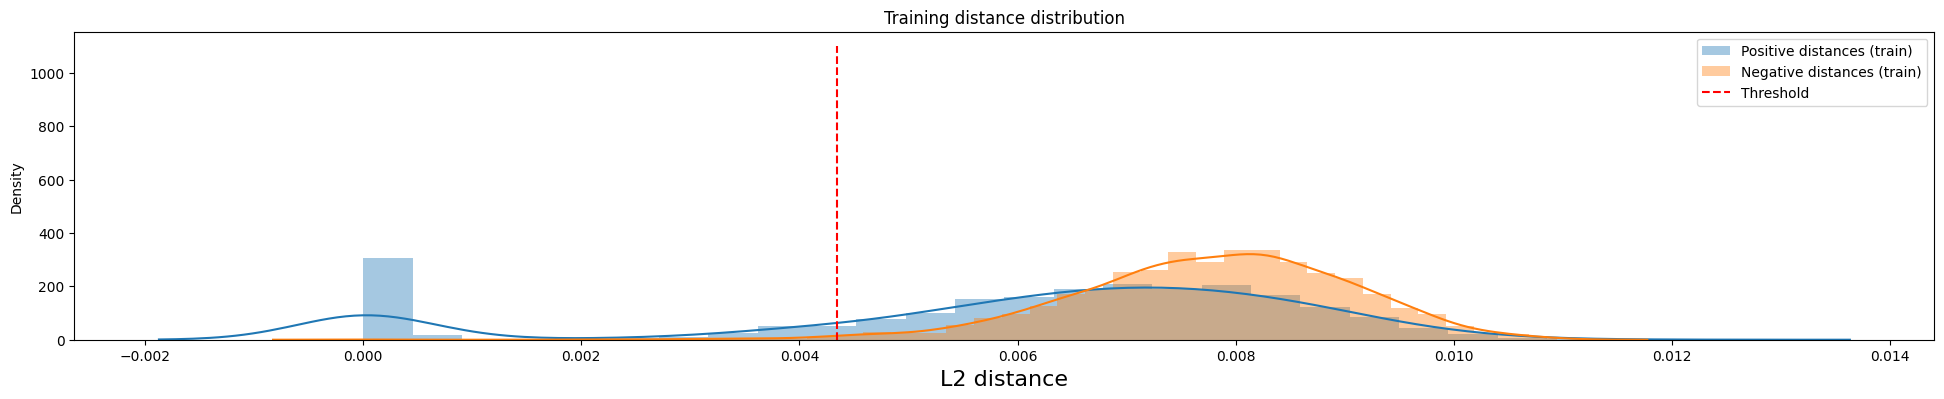

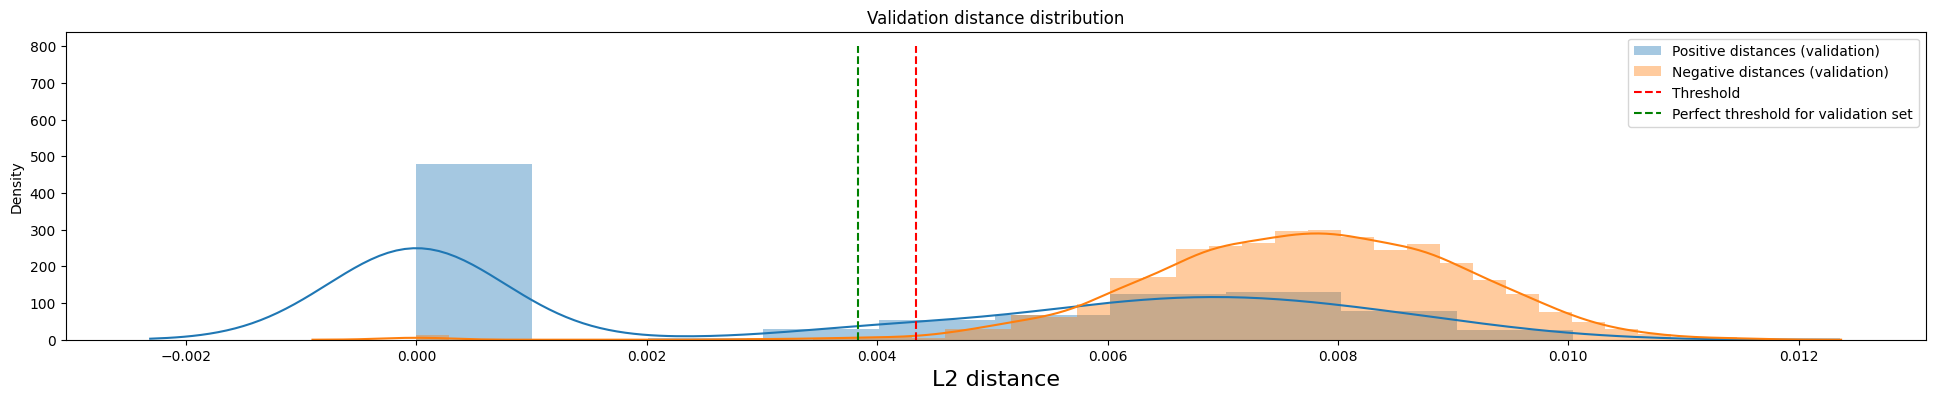

In [17]:
fig, ax = plt.subplots(figsize=(24, 4))

sns.distplot(train_pos_dists, label="Positive distances (train)")
sns.distplot(train_neg_dists, label="Negative distances (train)")

ax.vlines(train_thresh, 0, 1100, color="r", linestyle="--", label="Threshold")
ax.set_title("Training distance distribution")

ax.set_xlabel("L2 distance", fontsize=16)
ax.legend();

plt.show()

fig, ax = plt.subplots(figsize=(24, 4))

sns.distplot(val_pos_dists, label="Positive distances (validation)")
sns.distplot(val_neg_dists, label="Negative distances (validation)")

ax.vlines(train_thresh, 0, 800, color="r", linestyle="--", label="Threshold")
ax.vlines(val_thresh, 0, 800, color="g", linestyle="--", label="Perfect threshold for validation set")

ax.set_xlabel("L2 distance", fontsize=16)
ax.legend()
ax.set_title("Validation distance distribution")

plt.show()